# HyDE（Hypothetical Document Embeddings：仮の文書の埋め込み）

実行にはChatGPT(Chat Completion)対応のモデルと埋め込みモデル(text-embedding-ada-002)が必要です。

In [1]:
!python -m pip install openai
!python -m pip install python-dotenv
!python -m pip install numpy
!python -m pip install matplotlib
import json
from openai import AzureOpenAI
from dotenv import load_dotenv
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
load_dotenv()
deployment = os.environ['DPLOYMENT']
embedding_deployment = os.environ['EMBEDDING_DPLOYMENT']
apikey = os.environ['API_KEY']
base = os.environ['BASE']
api_version=os.environ['API_VERSION']

In [3]:
client = AzureOpenAI(
  azure_endpoint = base, 
  api_key=apikey,  
  api_version=api_version
)

# データの準備

In [4]:
# ユーザーから入力される質問
question = "Surfaceの電源が入りません。どうすればよいですか？"

In [5]:
# 正解データ
correct_answer = """まず、Surfaceに接続されているすべてのアクセサリを取り外し、電源ボタンを押してみてください。
それでも電源が入らない場合は、Surfaceを充電し、電源ボタンを長押しして強制的にシャットダウンし、再起動してみてください。
さらに、Surfaceの電源が入っていても特定の画面で停止している場合は、その画面に応じた手順を実行してください。
対面サポートや自己修復のオプションも提供されています。上記の手順を試しても問題が解決しない場合は、サポート窓口でお問い合わせください。"""

In [6]:
# 不正解データ（実際に同じナレッジベースにはいってそうな似ている回答）
incorrect_answer = """まず、Xboxに使用しているコンセントが他のデバイスでは機能することを確認します。
電源ケーブルがコンセントとXbox本体にしっかり接続されていることを確認します。
Xbox本体に同梱の電源ケーブルを使用していることを確認します。お住まいの国や地域に適した電源ケーブルが同梱されています。
それでも本体の電源が入らない場合は、本体の交換が必要です。交換を依頼するには、Microsoft アカウントで [デバイス サービス と修理] にサインインして、サービス注文を送信します。
"""

In [7]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# まずは質問と回答を単純比較してみる

In [8]:
question_vector = client.embeddings.create(
    input = question,
    model= embedding_deployment
).data[0].embedding

In [9]:
correct_answer_vector = client.embeddings.create(
    input = correct_answer,
    model= embedding_deployment
).data[0].embedding

In [10]:
incorrect_answer_vector = client.embeddings.create(
    input = incorrect_answer,
    model= embedding_deployment
).data[0].embedding

In [11]:
vs_correct_answer = cosine_similarity(question_vector,correct_answer_vector)
vs_incorrect_answer = cosine_similarity(question_vector,incorrect_answer_vector)

In [12]:
print("vs_correct_answer:"+str(vs_correct_answer))
print("vs_incorrect_answer:"+str(vs_incorrect_answer))

vs_correct_answer:0.8898275927854662
vs_incorrect_answer:0.8492056751258446


# HyDEでやってみる

In [13]:
hypothetical_gen_instruction = f"""Please write a passage to answer the question
Question: {question}
Passage:
"""

In [14]:
hypothetical_answer = client.chat.completions.create(
    model=deployment,
    messages=[
        {"role": "system", "content": "You are an AI assistant."},
        {"role": "user", "content": hypothetical_gen_instruction},
    ],
    temperature=0
).choices[0].message.content
print(hypothetical_answer)

Surfaceの電源が入らない場合、以下の手順を試してみてください。

1. 充電を確認する:
   - 電源アダプターとケーブルが正しく接続されていることを確認してください。
   - 別のコンセントを試すか、他のデバイスでアダプターが機能するかを確認してください。
   - Surfaceが十分に充電されているかを確認するために、少なくとも30分間充電してください。

2. 電源ボタンの長押し:
   - 電源ボタンを長押しして、10秒以上保持してから離してください。これにより、強制的にシャットダウンされる場合があります。
   - その後、もう一度電源ボタンを短く押して、通常通りに起動を試みてください。

3. 二段階リセットを試す:
   - Surfaceによっては、二段階リセットが有効な場合があります。電源ボタンと音量アップボタンを同時に15秒以上押し続けてください。
   - ボタンから手を離した後、10秒待ってから電源ボタンを押して通常起動を試みてください。

4. アクセサリーの取り外し:
   - すべての外部デバイス、SDカード、外部モニター、USBデバイスなどを取り外してください。これらが原因で起動に問題が生じることがあります。

5. サポートとの連絡:
   - 上記の手順で問題が解決しない場合は、Microsoftのサポートに連絡することをお勧めします。保証の範囲内であれば、修理または交換の手配が可能です。

注意: これらの手順を行う前に、Surfaceが熱を持っていないことを確認してください。過度に熱くなっている場合は、冷却してから上記の手順を試してください。また、水濡れや物理的な損傷がないかも確認してください。


In [15]:
hypothetical_answer_vector = client.embeddings.create(
    input = hypothetical_answer,
    model= embedding_deployment
).data[0].embedding

In [16]:
vs_correct_answer_hyde = cosine_similarity(hypothetical_answer_vector,correct_answer_vector)
vs_incorrect_answer_hyde = cosine_similarity(hypothetical_answer_vector,incorrect_answer_vector)

In [17]:
print("vs_correct_answer_hyde:"+str(vs_correct_answer_hyde))
print("vs_incorrect_answer_hyde:"+str(vs_incorrect_answer_hyde))

vs_correct_answer_hyde:0.9568607484152887
vs_incorrect_answer_hyde:0.8885138499339678


# まとめ

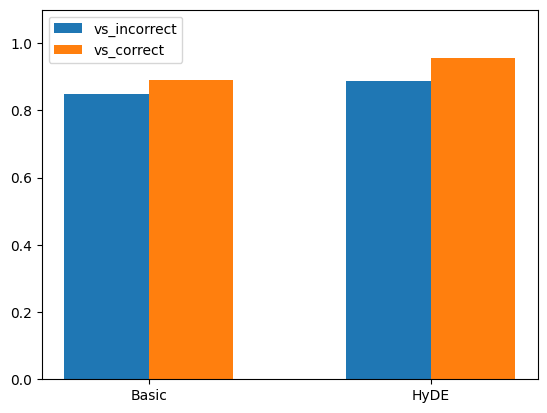

In [18]:
vs_correct = [vs_correct_answer,vs_correct_answer_hyde]
vs_incorrect = [vs_incorrect_answer,vs_incorrect_answer_hyde]
x = [1, 2]
labels=['Basic', 'HyDE']

plt.bar(np.array(x)-0.15,vs_incorrect, width=0.3, label='vs_incorrect', align="center")
plt.bar(np.array(x)+0.15,vs_correct, width=0.3, label='vs_correct', align="center")

plt.legend(loc=2)
plt.xticks([1, 2], labels)
plt.ylim(0,1.1)
plt.show()